# Research on AAST (Android-based AST Model)

## Motivation
Java Identifier is too abstract and cannot distinguish between an Android identity and Java identity. (Experiments 1)

Traditional Java-based model is not "optimized" to Android analysis. (Experiments 3)

Applying Java-based AST to Android analysis might cause errors in Decoding from AST->Code (Experiment 4)

Implementation: Provide a tree-based representative of AST and AAST to demonstrate the different

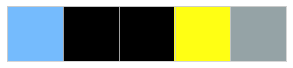

In [470]:
# Machine Learning with AAST 
#!conda install pandas matplotlib seaborn -y
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
#colors = ["black",  "greyish", "grey", "light grey", "cool grey"]
#colors = ["sky blue",  "red", "black", "yellow", "cool grey"]    # Use this for ex1.pdf and distant.pdf
colors = ["sky blue",  "black", "black", "yellow", "cool grey"]

sns.palplot(sns.xkcd_palette(colors))
sns.set_palette(sns.xkcd_palette(colors))

import logging

logging.basicConfig(level=logging.DEBUG)

#logging.disable(logging.NOTSET)   ## UNCOMMENT FOR RUNNING AS DEBUGGING
logging.disable(logging.DEBUG)   ## UNCOMMENT IF DON'T WANT TO SEE DEBUG

## Make ast model and aast dataframe

In [471]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

class ast_dataset(object):
    """Compare aast and ast in the source code."""
    def __init__(self, source_name):
        self.data = None
        self.ast_vol = {}
        self.aast_vol = {}
        self.data_path = os.path.join("experiments/data", source_name)
        self.source_name = source_name
        self.sum_df = pd.DataFrame(columns=["data_index","length",
                                            "ast_length", "aast_length",
                                            "dup_ast","dup_aast"])  

    def dataLoad(self, limit=5):
        df_count = 0
        columns = ['code','ast', 'aast']
        self.loadVocabulary()
        ## DEBUG
        logging.debug("The length of AST Vocabolary: %d" % len(self.ast_vol))
        logging.debug("The length of AAST Vocabolary: %d" % len(self.aast_vol))

        while(True):
            check = os.path.join(self.data_path, "%s_df_%d" % (self.source_name,
                                                           df_count))
            if df_count > limit:
                break
            if os.path.isfile(check):
                df = pd.read_pickle(check)
                self.summary(df_count+1, df)
                df_count += 1
            else:
                break
        
    def dataLoad_return_df(self, limit=5):
        df_count = 0
        columns = ['code','ast', 'aast']
        final_df = pd.DataFrame(columns=columns)
        self.loadVocabulary()
        ## DEBUG
        logging.debug("The length of AST Vocabolary: %d" % len(self.ast_vol))
        logging.debug("The length of AAST Vocabolary: %d" % len(self.aast_vol))
        data_frames = []
        while(True):
            check = os.path.join(self.data_path, "%s_df_%d" % (self.source_name,
                                                               df_count))
            if df_count > limit:
                break
            if os.path.isfile(check):
                df = pd.read_pickle(check)
                self.summary(df_count+1, df)
                df_count += 1
                data_frames.append(df)
            else:
                break
            final_df = pd.concat(data_frames)
        return final_df
                        
    def loadVocabulary(self):
        file_name = os.path.join(self.data_path, "%s_ast_vol" % self.source_name)
        file_name2 = os.path.join(self.data_path, "%s_aast_vol" % self.source_name)
        self.aast_vol = pd.read_pickle(file_name) # Data Generation outputs reversed file name (ast - aast)
        self.ast_vol = pd.read_pickle(file_name2)
            
    def makeGraph(self):
        self.sum_df.index += 1
        ax = self.sum_df[['dup_ast','dup_aast']].plot(kind='bar', 
                                                      title ="AST vs AAST comparison (Accurate)", 
                                                      figsize=(15, 10), legend=True, fontsize=14)
        ax.set_xlabel("Dataframe Number", fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        plt.savefig('duplicated.pdf')
        plt.show()
    
    def makeGraph2(self):
            #self.sum_df.index += 1
            ax = self.sum_df[['ast_length','aast_length']].plot(kind='line', 
                                                                style=['-','k--'],
                                                                title ="AST vs AAST comparison (Compression Rate)", 
                                                                figsize=(7, 4), legend=True)
            ax.set_xlabel("Dataframe Number")
            ax.set_ylabel("Value (Lower is better)")
            plt.savefig("ex1.pdf")
            plt.show()
                        
    def summary(self, count, df):
            """Show the summaries of a df."""
            length = len(df.index)
            dup_df_j = df[df.duplicated(['ast'])]  # Java
            dup_df_a = df[df.duplicated(['aast'])]  # Android
            df['ast_length'] = df['ast'].apply(len)
            df['aast_length'] = df['aast'].apply(len)
            
            ### DEBUG ONLY
            logging.debug("The length of dataframe: %d " % length)
            logging.debug("Checking the number of duplicated in each model. Lower number means less detail.")
            logging.debug("Higher number means more detail.")
            logging.debug("   Number of duplicated JAVA-ast: %d " % len(dup_df_j))
            logging.debug("   Number of duplicated Android-ast: %d"  % len(dup_df_a))
            
            self.sum_df = self.sum_df.append({"data_index":count, "length": length, 
                                              "ast_length": df['ast_length'].sum(),
                                              "aast_length": df['aast_length'].sum(),
                                              "dup_ast":len(dup_df_j), "dup_aast": len(dup_df_a)}, ignore_index=True)

### LOAD DATASET FOR DATAFRAMES (COMPARE DUPLICATED BETWEEN AST AND AAST

In [472]:
obj = ast_dataset("aosp_v10_2")
df = obj.dataLoad_return_df(37) # Index = 2
#obj.dataLoad(37)

total_code = 0
for index, row in obj.sum_df.iterrows():
    total_code += row['length']
total_code


1149206

## Implementation 1:

#### We could see that all 37 dataframes from AOSP return a higher number of duplicated between abstract and real-code. With this result, we could see that the AAST could provide more detail in comparison with AST.

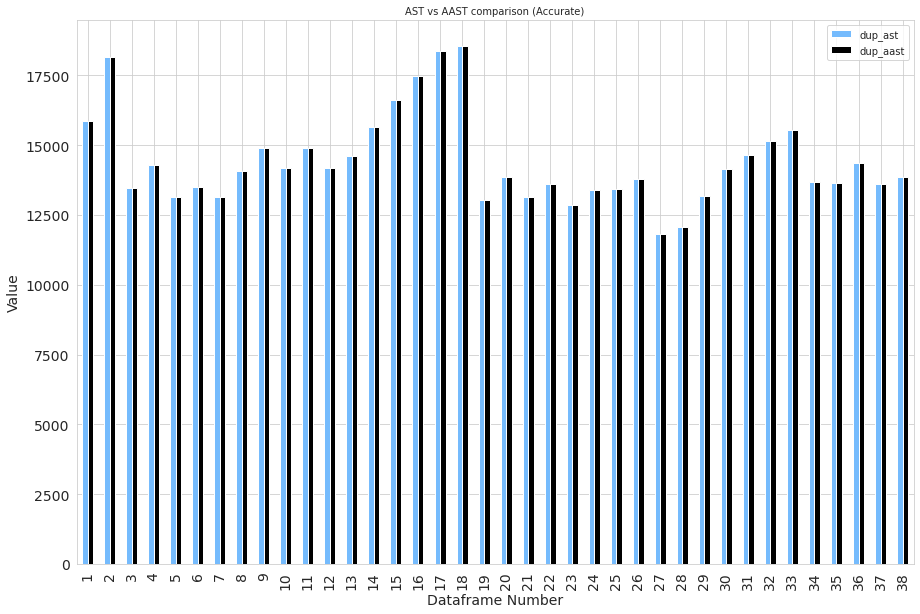

In [473]:
obj.makeGraph()

## Implementation 2:

#### By checking the size of vocabulary, we could see the reverse result. The vocabulary size of AAST is higher in comparison with traidtional AST. 

#### Advantage: Bigger vocabulary size means more detail in the case of reverting from AST to code. 

In [411]:
print(len(obj.ast_vol))
print(len(obj.aast_vol))

186641
190042


## Implementation 3: (Compression)

#### Size of Dataframes between AST and AAST
We could see that AAST could consume less storage than AST 

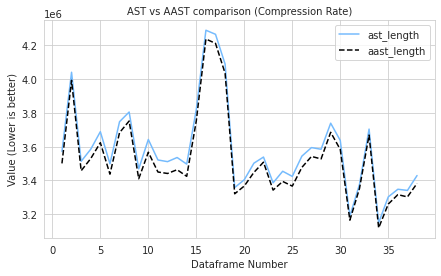

In [379]:
obj.makeGraph2()

In [380]:
count_unk_aast = 0
for k,v in obj.aast_vol.items():
    if "UNK" in k:
        count_unk_aast += 1
print(count_unk_aast)

186033


In [381]:
count_unk_ast = 0
for k,v in obj.ast_vol.items():
    if "UNK" in k:
        count_unk_ast += 1
print(count_unk_ast)

186547


## Implementation 4: (Decoding Accurate)

#### Check The Accurate between Decoding AST -> Code and AAST -> Code  

##### How: Provide a list of sample code, performing Code to AST and convert back to Code using the datasets

To determine the accuracy: We use the string distance algorithm.

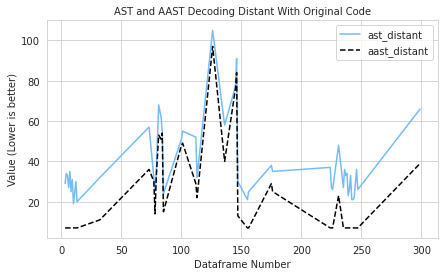

In [382]:
!{sys.executable} -m pip install textdistance
import textdistance

def decodingAST(input):
    ## Pairs were separated by "__" and coupled by "--"
    pairs = input.split("___")
    out = ""
    for pair in pairs:
        if "--" in pair:
            value = pair.split("--")[1]
            if out != "":
                out += " "
            out += value
    return out

def makeGraph(df):
    ax = df[['ast_distant','aast_distant']].plot(
        kind='line', title ="AST and AAST Decoding Distant With Original Code", 
        style=['-','k--'],
        figsize=(7, 4), legend=True)
    ax.set_xlabel("Dataframe Number")
    ax.set_ylabel("Value (Lower is better)")
    plt.savefig("distant.pdf")
    plt.show()

df = obj.dataLoad_return_df(5) # Index = 2
decode_df = pd.DataFrame(columns=["code", "code_length","ast",
                                                "ast_distant", "aast",
                                                "aast_distant"])
count = 0
for index, row in df.iterrows():
    if count > 300:
        break
    ast_dec_out = decodingAST(row['ast']).strip()
    aast_dec_out = decodingAST(row['aast']).strip()
    origin_code = row['code'].strip()
    #print("AST_OUT: %s" % ast_dec_out)
    #print("AAST_OUT: %s" % aast_dec_out)
    #print("ORIGIN_CODE: %s" % origin_code)
    ast_vs_ori = textdistance.hamming(ast_dec_out, origin_code)
    aast_vs_ori = textdistance.hamming(aast_dec_out, origin_code)
    #print("Distance AST: %d"  % ast_vs_ori)
    #print("Distance AAST: %d"  % aast_vs_ori)
    decode_df = decode_df.append({"code": origin_code, "code_length": len(origin_code), "ast": ast_dec_out,
                     "ast_distant": ast_vs_ori, "aast": aast_dec_out,
                     "aast_distant": aast_vs_ori}, ignore_index=True)
    count += 1
graph_aast_ast = decode_df.loc[decode_df['ast_distant'] > decode_df['aast_distant']]
makeGraph(graph_aast_ast)

In [383]:
graph_ast_aast = decode_df.loc[decode_df['ast_distant'] < decode_df['aast_distant']]
print(graph_ast_aast)

Empty DataFrame
Columns: [code, code_length, ast, ast_distant, aast, aast_distant]
Index: []


## Tree Examples of AAST and AST

#### This is the tree representative of a code generated by AAST and AST


    public static final Parcelable.Creator<SenderKey> CREATOR =



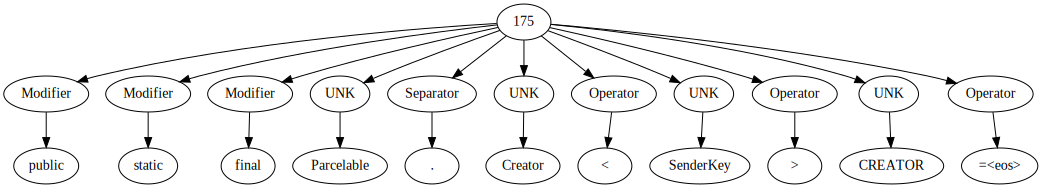

In [384]:
!{sys.executable} -m pip install graphviz

from graphviz import Digraph

def gen_tree(input, name, code_num="Code", fname="gen_tree", out=0):
    dot = Digraph(comment=name)
    pairs = input.split("___")
    node_num = 0
    dot.node("Root", code_num)
    for pair in pairs:
        if "--" not in pair:
            continue
        t = pair.split("--")[0]
        v = pair.split("--")[1]
        dot.edge("Root", "%s" % (node_num), constrant='false')
        dot.node("%s" % node_num, t)
        node_num+= 1
        dot.node("%s" % node_num, v)
        dot.edge("%s" % (node_num - 1),"%s" % node_num, constrant='false')
        node_num+= 1
    # Save as svg file
    if out == 1:
        dot.format = 'pdf'
        dot.view(filename=fname, directory='./')
    # Visualize the graph
    display(dot)

## We choose the code line 175 (since it showsa large distant between AST and AAST)
code_175 = df.iloc[175]
print(code_175['code'])
gen_tree(code_175['ast'], 'AST', '175', "ast_175")

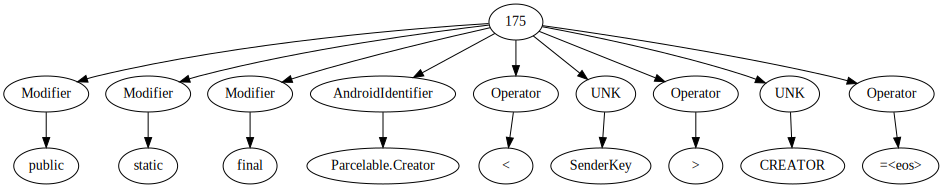

In [385]:
gen_tree(code_175['aast'], 'AAST', '175', "aast_175")

                                + cursor.getInt(7));



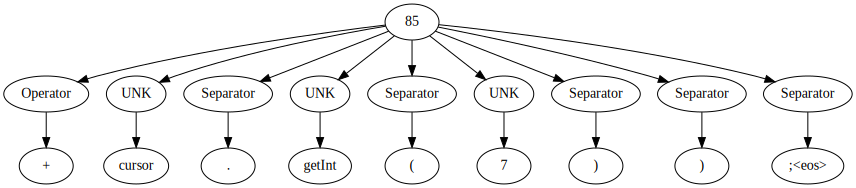

In [386]:
## We choose the code line 85 (since it showsa large distant between AST and AAST)
code_85 = df.iloc[85]
print(code_85['code'])
gen_tree(code_85['ast'], 'AST', '85', "ast_85")

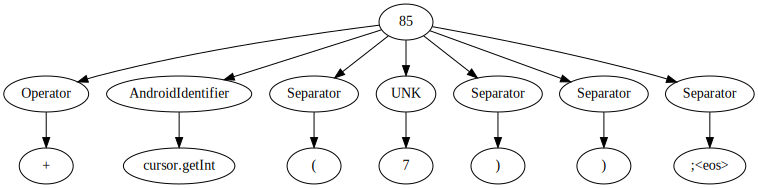

In [387]:
gen_tree(code_85['aast'], 'AAST', '85', "aast_85")

# Token-Based Signature Model

### A model for creating signature code based on Token
The result has shown that AAST always generates more signature than normal AST (More detail on code structure). 

In [412]:
def token_based_sig(input):
    ## Pairs were separated by "__" and coupled by "--"
    pairs = input.split("___")
    out = ""
    for pair in pairs:
        if "--" in pair:
            token_type = pair.split("--")[0]
            if out != "":
                out += "-"
            out += token_type
    return out

token_df = pd.DataFrame(columns=["index", "code", "ast_token","aast_token"])
count = 0
for index, row in df.iterrows():
    ast_tok_out = token_based_sig(row['ast']).strip()
    aast_tok_out = token_based_sig(row['aast']).strip()
    if "AndroidIdentifier" in aast_tok_out:
        count += 1
        origin_code = row['code'].strip()
        token_df = token_df.append({"index":count, "code": origin_code, 
                                    "ast_token": ast_tok_out, 
                                    "aast_token": aast_tok_out}, ignore_index=True)
    if count > 10000:
        break


In [413]:

unique_tok_ast = token_df[0:1000].ast_token.unique()  # Java
unique_tok_aast = token_df[0:1000].aast_token.unique()  # Android

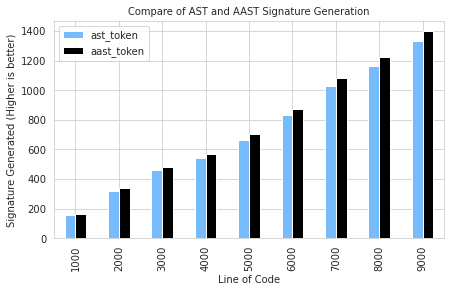

In [414]:
token_df_graph = pd.DataFrame(columns=["index", "ast_token", "aast_token"])
start = 0
def makeGraphTokenSig(df):
    labels = list(range(1000,11000,1000))
    ax = df[['ast_token','aast_token']].plot(
        kind='bar', title ="Compare of AST and AAST Signature Generation",
        figsize=(7, 4), legend=True)
    ax.set_xlabel("Line of Code")
    ax.set_xticklabels(labels)
    ax.set_ylabel("Signature Generated (Higher is better)")
    plt.savefig("token_sig.pdf")
    plt.show()

total_tok_ast = 0
total_tok_aast = 0
for i in range(0,10000,1000): 
    unique_tok_ast = token_df[start:i].ast_token.unique()  # Java
    unique_tok_aast = token_df[start:i].aast_token.unique()  # Android
    total_tok_ast += len(unique_tok_ast)
    total_tok_aast += len(unique_tok_aast)
    if len(unique_tok_ast) > 0:
        token_df_graph = token_df_graph.append({"index": start, "ast_token": total_tok_ast,
                                               "aast_token": total_tok_aast}, ignore_index=True)
    start = i

makeGraphTokenSig(token_df_graph)

### Indistinguish Between Java-AST and Android-AST in traditional methods

In [415]:
android_sig = []
java_sig = []
for index, row in df.iterrows():
    if "import" in row['code']:
        if "java" in row['code']:
            java_sig.append(token_based_sig(row['ast']))
        if "AndroidIdentifier" in row['aast']:
            android_sig.append(token_based_sig(row['ast']))
            
set(java_sig).intersection(android_sig)

{'Keyword-Modifier-UNK-Separator-UNK-Separator-UNK-Separator-UNK-Separator',
 'Keyword-Modifier-UNK-Separator-UNK-Separator-UNK-Separator-UNK-Separator-UNK-Separator',
 'Keyword-UNK-Separator-UNK-Separator-Operator-Separator',
 'Keyword-UNK-Separator-UNK-Separator-UNK-Separator',
 'Keyword-UNK-Separator-UNK-Separator-UNK-Separator-UNK-Separator',
 'Keyword-UNK-Separator-UNK-Separator-UNK-Separator-UNK-Separator-UNK-Separator'}

In [416]:
android_sig2 = []
java_sig2 = []
for index, row in df.iterrows():
    if "import" in row['code']:
        if "java" in row['code']:
            java_sig2.append(token_based_sig(row['aast']))
        if "AndroidIdentifier" in row['aast']:
            android_sig2.append(token_based_sig(row['aast']))

set(java_sig2).intersection(android_sig2)

set()

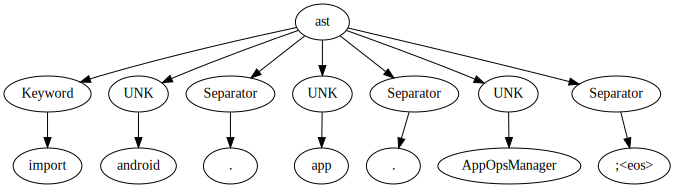

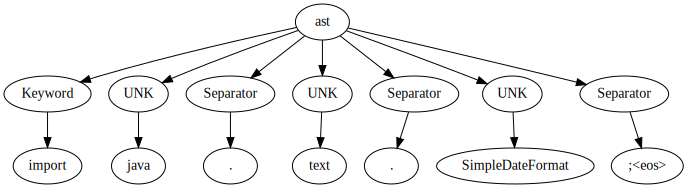

In [417]:
count_error = 0
fst_printed = 0
sec_printed = 0
for index, row in df.iterrows():
    if token_based_sig(row['ast']) == "Keyword-UNK-Separator-UNK-Separator-UNK-Separator":
        if fst_printed == 0:
            gen_tree(row['ast'], 'AST', 'ast', "ast_error1", 1)
            fst_printed = 1
        else:
            if "java" in row['code']:
                gen_tree(row['ast'], 'AST', 'ast', "ast_error2", 1)
                sec_printed = 1
    if sec_printed == 1:
        break
    

# Predictor Model

### A simple model for predicting the next word ( Usually used for code completion and code generation)

In [457]:
## Predictor Model: Import
import_ast = []
import_aast = []
import_ast_iter = []
import_aast_iter = []
df_2 = obj.dataLoad_return_df(0) # Index = 2
iter_df = pd.DataFrame(columns=["index", "code", "ast_iter", "aast_iter"])
count = 0
for index, row in df_2.iterrows():
    if "import" in row['code']:
        count += 1
        #print("Iter_len: %d" % len(iter_df))
        ast_dec_out = decodingAST(row['ast']).strip()
        aast_dec_out = decodingAST(row['aast']).strip()
        import_ast.append(ast_dec_out.split(" ")[1])
        
        import_aast.append(aast_dec_out.split(" ")[1])
        ast_iter_count = len(ast_dec_out.split(" ")) - 1
        aast_iter_count = len(aast_dec_out.split(" ")) - 1
        import_ast_iter.append(ast_iter_count)
        import_aast_iter.append(aast_iter_count)
        iter_df = iter_df.append({"index":count, 
                                  "code":row['code'], 
                                  'ast_iter': ast_iter_count,
                                  'aast_iter': aast_iter_count},ignore_index=True)
        if count > 500:
            break
len(iter_df)

501

In [460]:
## Check for same length 
diff_df = iter_df[iter_df['ast_iter'] != iter_df['aast_iter']]
diff_df

index                                             code ast_iter aast_iter
2       3              import android.app.AppOpsManager;\n        6         2
3       4        import android.content.ContentResolver;\n        6         2
4       5          import android.content.ContentValues;\n        6         2
5       6                import android.content.Context;\n        6         2
6       7      import android.content.pm.PackageManager;\n        8         2
..    ...                                              ...      ...       ...
491   492                     import android.app.Dialog;\n        6         2
492   493                      import android.os.Bundle;\n        6         2
498   499                import android.content.Context;\n        6         2
499   500         import android.content.res.TypedArray;\n        8         2
500   501  import android.content.res.XmlResourceParser;\n        8         2

[262 rows x 4 columns]

In [396]:
#import_ast

In [397]:
#import_aast

In [398]:
#import_ast_iter

In [399]:
#import_aast_iter

In [400]:
#iter_df

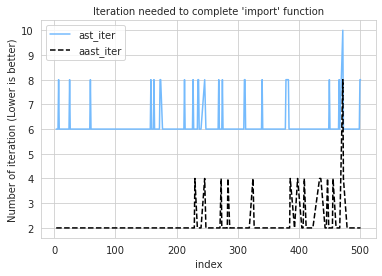

In [462]:
def makeGraphIter(iter_df):
    plt.clf()
    ax = plt.gca()
    iter_df.plot(kind='line', style='-', x='index',y='ast_iter',ax=ax)
    iter_df.plot(kind='line', style='--', color='black', x='index',y='aast_iter', ax=ax)

    ax.set_ylabel("Number of iteration (Lower is better)")
    ax.set_title("Iteration needed to complete 'import' function")
    plt.savefig("import_iter.pdf")
    plt.show() 
    
makeGraphIter(diff_df)

### List of Improved Code 

In [463]:
df_3 = obj.dataLoad_return_df(0) # Index = 2
iter_df2 = pd.DataFrame(columns=["index", "code", "ast_iter", "aast_iter"])
count = 0
code_pattern = {}
condition_count = 0
import_count = 0
normal_count = 0
declare_count = 0
conditions = ["if", "while", "else", "switch"]
declares = ["public", "private", "final", "boolean", "int", "String"]
total_count = {}

for index, row in df_3.iterrows():
    count += 1
    #print("Iter_len: %d" % len(iter_df))
    ast_dec_out = decodingAST(row['ast']).strip()
    aast_dec_out = decodingAST(row['aast']).strip()
    ast_iter_count = len(ast_dec_out.split(" ")) - 1
    aast_iter_count = len(aast_dec_out.split(" ")) - 1
    if aast_iter_count < ast_iter_count:
        iter_df2 = iter_df2.append({"index":count, "code":row['code'], 
                                  'ast_iter': ast_iter_count,
                                  'aast_iter': aast_iter_count},ignore_index=True)
        first = row['code'].split()[0]
        if first in conditions:
            condition_count += 1
            first = "conditions"
        elif(first in declares):
            declare_count += 1
            first = 'declarations'        
        elif(first.strip() == "import"):
            import_count += 1
        else:
            normal_count += 1
            first = 'others'
        if first in total_count:
            total_count[first] += 1
        else:
            total_count[first] = 1
    if count > 10000:
        break
#iter_df2
print("Normal: %d, Import: %d, Declare: %d, Conditions: %d" % (normal_count, import_count,
                                                              declare_count, condition_count))
sorted_count = sorted(total_count.items(), key=lambda kv: kv[1])
sorted_count

Normal: 323, Import: 641, Declare: 54, Conditions: 38


[('conditions', 38), ('declarations', 54), ('others', 323), ('import', 641)]

In [464]:
def graphCount(input):
    y_list = []
    x_list = []
    for index in range(len(input)):
        k = input[index][0]
        v = input[index][1]
        y_list.append(k)
        x_list.append(v)
    plt.figure(figsize=(7, 7))
    freq_series = pd.Series.from_array(x_list)
    ax = freq_series.plot(kind='bar')
    ax.set_title('Different Types of Code', size=14)
    ax.set_xlabel('Type of Code', size=13)
    ax.set_ylabel('Frequencies', size=13)
    ax.set_xticklabels(y_list)
    rects = ax.patches

    # Make some labels.
    labels = x_list

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom', size=12)
    plt.savefig("code_count.pdf")
    plt.show()
#input = sorted_count[len(sorted_count)-10:len(sorted_count)]
#graphCount(input)


In [474]:
# Code clone detection - token-based
import hashlib

## Create signature for token
def create_token_sig(ast):
    token_seq = []
    ast_elements = ast.split("__")
    for ele in ast_elements:
        if "--" in ele:
            tok = ele.split("--")[0][1:]
            token_seq.append(tok)
    return token_seq
   
## Hashing
def create_hash(token_str):
    hash_object = hashlib.md5(token_str.encode())
    return hash_object.hexdigest()
    
## Update dict
def update_dict(ast_hash, hash_code_dict, hash_count_dict, code):
    if ast_hash in hash_code_dict:
        # Exist, append
        code_array = hash_code_dict[ast_hash]
        code_array.append(code)
        # Assign back
        hash_code_dict[ast_hash]  = code_array
        # Add count
        hash_count_dict[ast_hash] += 1
    else:
        hash_code_dict[ast_hash] = [code]
        hash_count_dict[ast_hash]  = 1
    return hash_code_dict, hash_count_dict, hash_count_dict[ast_hash], hash_code_dict[ast_hash]

### Clone Comparison Between Notation-based and External-based Function
def clone_comparison(df):
    ast_hash_code_dict = {}
    ast_hash_count_dict = {}
    aast_hash_code_dict = {}
    aast_hash_count_dict = {}
    # df_index
    df_index = 0
    output_ast = []
    output_aast = []
    output_code = []

    count_df = pd.DataFrame(columns=["ast", "aast"])

    for index, row in df.iterrows():
        # Go all list
        ast = row['ast'].strip()
        aast = row['aast'].strip()
        code = row['code'].strip()
        # Create token
        ast_token = create_token_sig(ast)
        aast_token = create_token_sig(aast)
        # Create hash
        ast_hash = create_hash("_".join(ast_token))
        aast_hash = create_hash("_".join(aast_token))
        # Ignore the code that startswith import or package
        df_index += 1
        if code.startswith("import") or code.startswith("package"):
            continue
        # Put into dict {hash:[code]} that matches
        # Put also into count_dict {hash:count}
        ast_hash_code_dict, ast_hash_count_dict, ast_count_value, ast_code_arr = update_dict(ast_hash, ast_hash_code_dict, 
                                                                              ast_hash_count_dict, code)
        aast_hash_code_dict, aast_hash_count_dict, aast_count_value, aast_code_arr = update_dict(aast_hash, aast_hash_code_dict, 
                                                                              aast_hash_count_dict, code)
        count_df = count_df.append({"ast":ast_count_value, "aast":aast_count_value},ignore_index=True)

        if ast_count_value != aast_count_value:
            # The signature value are different between AST and AAST
            # Reset array since the order will be changed
            ast_hash_code_dict = {}
            ast_hash_count_dict = {}
            aast_hash_code_dict = {}
            aast_hash_count_dict = {}
            # Append to output
            output_ast.append(ast_code_arr)
            output_aast.append(aast_code_arr)
            output_code.append(code)
            #return ast_code_arr, aast_code_arr, code
    return output_ast, output_aast, output_code, count_df


ast, aast, code, count_df = clone_comparison(df)




In [475]:
ast_len = []
aast_len = []
iter_df4 = pd.DataFrame(columns=["match_index", "code", "ast", "aast"])
count = 0 
for i in range(len(code)):
    if code[i] in aast[i]:
        count += 1
        #print("Code: {}. AAST matched: {}. AST matched: {}".format(code[i], len(aast[i]), len(ast[i])))
        iter_df4 = iter_df4.append({"match_index":count, 
                                    "code": code[i],
                                    "ast_arr": ast[i], 
                                    "aast_arr": aast[i],
                                    "ast":len(ast[i]), 
                                    "aast":len(aast[i])},ignore_index=True)
        #ast_len.append(len(ast[i]))
        #aast_len.append(len(aast[i]))
iter_df4

match_index                                               code ast aast  \
0              1                         context.getPackageName());   2    1   
1              2  mBluetoothMonitor.registerListener(mMessengerD...   2    1   
2              3  startForeground(SERVICE_STARTED_NOTIFICATION_I...   3    1   
3              4  L.d(TAG, "Device connected: \t%s", device.getA...   2    1   
4              5               if (TextUtils.isEmpty(contactUri)) {   3    1   
...          ...                                                ...  ..  ...   
6351        6352  options.outWidth, options.outHeight, targetSize);   3    1   
6352        6353  Bitmap bitmap = DecodeUtils.decode(jc, fileDes...   2    1   
6353        6354    context.registerReceiver(mUsbReceiver, filter);   5    1   
6354        6355  ContentResolver resolver = mApplication.getCon...   2    1   
6355        6356            GalleryUtils.assertNotInRenderThread();   2    1   

                                               aast_arr  \
0                          [context.getPackageName());]   
1     [mBluetoothMonitor.registerListener(mMessenger...   
2     [startForeground(SERVICE_STARTED_NOTIFICATION_...   
3     [L.d(TAG, "Device connected: \t%s", device.get...   
4                [if (TextUtils.isEmpty(contactUri)) {]   
...                                                 ...   
6351  [options.outWidth, options.outHeight, targetSi...   
6352  [Bitmap bitmap = DecodeUtils.decode(jc, fileDe...   
6353  [context.registerReceiver(mUsbReceiver, filter);]   
6354  [ContentResolver resolver = mApplication.getCo...   
6355          [GalleryUtils.assertNotInRenderThread();]   

                                                ast_arr  
0     [message.toString());, context.getPackageName(...  
1     [context.startForegroundService(startIntent);,...  
2     [notificationManager.createNotificationChannel...  
3     [L.w(TAG, "Intent %s missing sender-key extra....  
4     [if (predicate.test(senderKey)) {, if (predica...  
...                                                 ...  
6351  [BitmapFactory.decodeFileDescriptor(fd, null, ...  
6352  [Bitmap newBitmap = bitmap.copy(Config.ARGB_88...  
6353  [Log.w(TAG, "decode fail with a given bitmap, ...  
6354  [String deviceName = usbDevice.getDeviceName()...  
6355  [cursor.close();, GalleryUtils.assertNotInRend...  

[6356 rows x 6 columns]

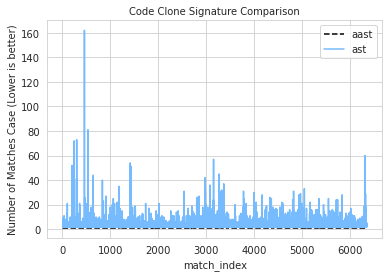

In [488]:
def makeGraphIter(iter_df):
    plt.clf()
    ax = plt.gca()
    iter_df.plot(kind='line', style='--', color='black', x='match_index',y='aast', ax=ax)
    iter_df.plot(kind='line', x='match_index',y='ast',ax=ax)
    ax.set_ylabel("Number of Matches Case (Lower is better)")
    ax.set_title("Code Clone Signature Comparison")
    plt.savefig("code_cloned_comparison.pdf")
    plt.show()
    
makeGraphIter(iter_df4)

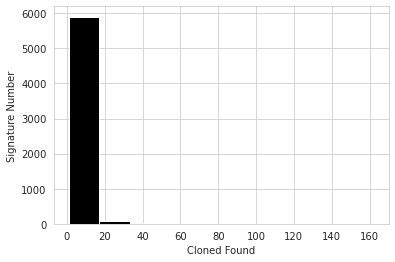

In [536]:
#iter_df4['aast']  = pd.to_numeric(iter_df4['aast'])
#ax = iter_df4['aast'].iloc[0:6000].hist(color='black')
#ax.set_xlabel("Cloned Found")
#ax.set_ylabel("Signature Number")
#plt.savefig("AAST_signature_count.pdf")

iter_df4['ast']  = pd.to_numeric(iter_df4['ast'])
ax = iter_df4['ast'].iloc[0:6000].hist(color='black')
ax.set_xlabel("Cloned Found")
ax.set_ylabel("Signature Number")
plt.savefig("AST_signature_count.pdf")


In [529]:
# Create table of content in latex
print(iter_df4.iloc[1].ast_arr)
print(iter_df4.iloc[1].aast_arr)
print(iter_df4.iloc[1].code)



['context.startForegroundService(startIntent);', 'mBluetoothMonitor.registerListener(mMessengerDelegate);']
['mBluetoothMonitor.registerListener(mMessengerDelegate);']
mBluetoothMonitor.registerListener(mMessengerDelegate);


In [530]:
print(iter_df4.iloc[3].ast_arr)
print(iter_df4.iloc[3].aast_arr)
print(iter_df4.iloc[3].code)

['L.w(TAG, "Intent %s missing sender-key extra.", intent.getAction());', 'L.d(TAG, "Device connected: \\t%s", device.getAddress());']
['L.d(TAG, "Device connected: \\t%s", device.getAddress());']
L.d(TAG, "Device connected: \t%s", device.getAddress());
